In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models, similarities, matutils
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

### Import cleaned datasets

In [3]:
df_train_s = pd.read_csv('C:/Users/ND/Documents/GitHub/drug-recommendation/df_train.csv')
# df_test_s = pd.read_csv('C:/Users/ND/Documents/GitHub/drug-recommendation/df_test.csv')

In [4]:
df_train_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148387 entries, 0 to 148386
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     148387 non-null  object 
 1   condition    148387 non-null  object 
 2   rating       148387 non-null  float64
 3   usefulCount  148387 non-null  int64  
 4   review       148386 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 5.7+ MB


In [5]:
#drop Nan value
df_train_s.dropna(inplace=True)

In [6]:
df_train_s.reset_index(inplace=True)

In [7]:
df_train_s['condition']


0                                 ADHD
1                        Birth Control
2                        Birth Control
3         Benign Prostatic Hyperplasia
4              Emergency Contraception
                      ...             
148381                   Birth Control
148382                 Nausea/Vomiting
148383            Rheumatoid Arthritis
148384             Underactive Thyroid
148385           Constipation, Chronic
Name: condition, Length: 148386, dtype: object

In [8]:
condition_list=df_train_s['condition'].tolist()

In [9]:
corpus_train=df_train_s.review
# corpus_test=df_test_s.review

In [10]:
#custom stopwords
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
n = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't",
     "mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in n:
    stop.remove(i)

a = ['mg', 'week', 'month', 'day', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 
     'august', 'september','october','november','december', 'iv','oral','pound',]
for j in a:
    stop.add(j)

### CountVectorizer

In [11]:
# Create a CountVectorizer for parsing/counting words
cv = CountVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.8)
# cv = CountVectorizer(ngram_range=(2, 2), min_df=10, max_df=0.8)

cv.fit(corpus_train)

CountVectorizer(max_df=0.8, min_df=0.01, ngram_range=(2, 2))

In [12]:
doc_word = cv.transform(corpus_train).transpose()

In [13]:
pd.DataFrame(doc_word.toarray(), cv.get_feature_names()).head()

,0,1,2,3,4,5,6,7,8,9,...,148376,148377,148378,148379,148380,148381,148382,148383,148384,148385
almost year,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
anxiety depression,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
back normal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
back pain,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
birth control,0,0,2,0,0,0,0,1,0,0,...,0,0,0,0,0,2,0,0,0,0


In [14]:
corpus = matutils.Sparse2Corpus(doc_word)

In [15]:
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [16]:
len(id2word)

84

### LDA

In [17]:
lda = models.LdaModel(corpus=corpus, num_topics=2, id2word=id2word, passes=10)

In [18]:
lda.print_topics()

[(0,
  '0.112*"birth control" + 0.060*"mood swing" + 0.058*"weight gain" + 0.049*"year old" + 0.043*"sex drive" + 0.043*"year ago" + 0.030*"felt like" + 0.028*"two week" + 0.028*"month ago" + 0.023*"not sure"'),
 (1,
  '0.317*"side effect" + 0.053*"no side" + 0.049*"feel like" + 0.047*"started taking" + 0.033*"panic attack" + 0.030*"first time" + 0.027*"much better" + 0.024*"blood pressure" + 0.023*"no longer" + 0.021*"go away"')]

In [19]:
lda_corpus = lda[corpus]
lda_corpus

In [20]:
lda_docs = [doc for doc in lda_corpus]

In [21]:
lda_docs[0:5]

[[(0, 0.12500572), (1, 0.8749943)],
 [(0, 0.49997523), (1, 0.50002474)],
 [(0, 0.583383), (1, 0.41661695)],
 [(0, 0.16666701), (1, 0.83333296)],
 [(0, 0.83332783), (1, 0.16667219)]]

In [22]:
len(lda_docs)

148386

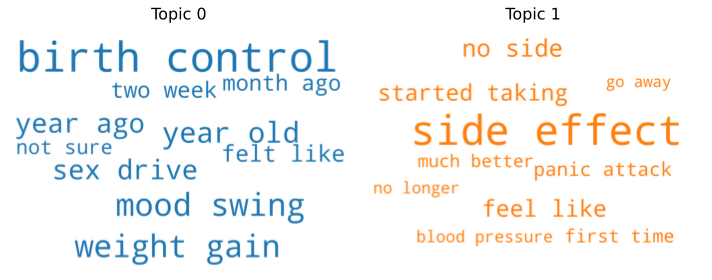

<Figure size 432x288 with 0 Axes>

In [23]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(10,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

plt.savefig('C:/Users/ND/Documents/GitHub/drug-recommendation/fig/wc_bigram_lda-2.svg')

In [24]:
lda1 = models.LdaModel(corpus=corpus, num_topics=4, id2word=id2word, passes=10)

In [25]:
lda1.print_topics()

[(0,
  '0.423*"side effect" + 0.096*"feel like" + 0.044*"no longer" + 0.042*"not sure" + 0.042*"taking pill" + 0.038*"could not" + 0.038*"work well" + 0.029*"would not" + 0.025*"not work" + 0.023*"anxiety depression"'),
 (1,
  '0.122*"mood swing" + 0.119*"weight gain" + 0.065*"first time" + 0.060*"much better" + 0.058*"two week" + 0.052*"blood pressure" + 0.044*"went away" + 0.034*"sex drive" + 0.031*"stop taking" + 0.031*"really bad"'),
 (2,
  '0.114*"started taking" + 0.110*"year old" + 0.097*"year ago" + 0.068*"felt like" + 0.063*"month ago" + 0.048*"lost lb" + 0.041*"dry mouth" + 0.039*"doctor prescribed" + 0.037*"week ago" + 0.037*"lost pound"'),
 (3,
  '0.191*"birth control" + 0.181*"side effect" + 0.097*"no side" + 0.060*"panic attack" + 0.046*"sex drive" + 0.039*"go away" + 0.033*"two month" + 0.033*"take pill" + 0.032*"weight loss" + 0.030*"last year"')]

In [26]:
all_topics = lda1.get_document_topics(corpus)
all_topics

In [27]:
num_docs = len(all_topics)

In [28]:
num_topics=4

lda_scores = np.empty([num_docs, num_topics])

for i in range(0, num_docs):
    lda_scores[i] = np.array(all_topics[i]).transpose()[1]

In [29]:
lda_corpus1 = lda1[corpus]
lda_corpus1

In [30]:
lda_docs1 = [doc for doc in lda_corpus1]

In [31]:
lda_docs1[0:5]

[[(0, 0.07315263), (1, 0.06782119), (2, 0.7965254), (3, 0.06250073)],
 [(0, 0.20051344), (1, 0.4642845), (2, 0.035714414), (3, 0.29948762)],
 [(0, 0.0431723), (1, 0.53951305), (2, 0.042310078), (3, 0.37500453)],
 [(0, 0.74725103), (1, 0.08333335), (2, 0.08333335), (3, 0.08608221)],
 [(0, 0.41666177), (1, 0.4166701), (2, 0.08333409), (3, 0.08333406)]]

In [32]:
len(lda_docs1)

148386

In [33]:
def dominant_topic(ldamodel, corpus, texts):
     #Function to find the dominant topic in each review
     sent_topics_df = pd.DataFrame() 
     # Get main topic in each review
     for i, row in enumerate(ldamodel[corpus]):
         row = sorted(row, key=lambda x: (x[1]), reverse=True)
         # Get the Dominant topic, Perc Contribution and Keywords for each review
         for j, (topic_num, prop_topic) in enumerate(row):
             if j == 0:  # => dominant topic
                 wp = ldamodel.show_topic(topic_num,topn=4)
                 topic_keywords = ", ".join([word for word, prop in wp])
                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
             else:
                 break
     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     contents = pd.Series(texts)
     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
     return(sent_topics_df)

df_dominant_topic = dominant_topic(ldamodel=lda1, corpus=corpus, texts=df_train_s['review']) 
df_dominant_topic.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,review
0,2.0,0.7968,"started taking, year old, year ago, felt like",son halfway fourth intuniv became concerned be...
1,1.0,0.4643,"mood swing, weight gain, first time, much better",used take another contraceptive pill cycle hap...
2,1.0,0.5395,"mood swing, weight gain, first time, much better",first time using form birth control glad went ...
3,0.0,0.7473,"side effect, feel like, no longer, not sure",nd started work rock hard erection however exp...
4,1.0,0.4167,"mood swing, weight gain, first time, much better",pulled cummed bit took plan b hour later took ...


In [60]:
#export topic keywords to csv file for later use
export_csv = df_dominant_topic.to_csv(r'C:/Users/ND/Documents/GitHub/drug-recommendation/df_dominant_topic.csv', index = None, header=True)

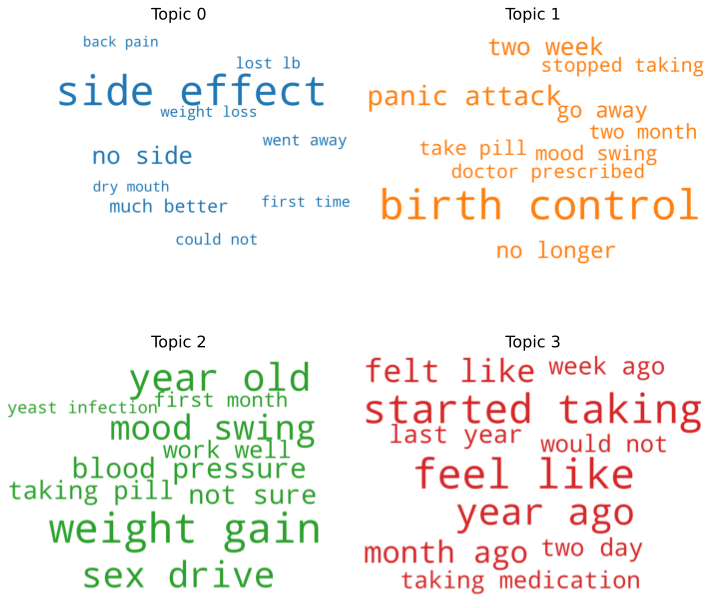

<Figure size 432x288 with 0 Axes>

In [62]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics1 = lda1.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words1 = dict(topics1[i][1])
    cloud.generate_from_frequencies(topic_words1, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

plt.savefig('C:/Users/ND/Documents/GitHub/drug-recommendation/fig/wc_bigram_lda-4.svg')

In [63]:
lda2 = models.LdaModel(corpus=corpus, num_topics=6, id2word=id2word, passes=10)

In [64]:
lda2.print_topics()

[(0,
  '0.103*"mood swing" + 0.086*"sex drive" + 0.085*"no longer" + 0.068*"two month" + 0.062*"last year" + 0.055*"would not" + 0.052*"gained weight" + 0.050*"yeast infection" + 0.049*"would recommend" + 0.048*"not work"'),
 (1,
  '0.160*"started taking" + 0.072*"not sure" + 0.072*"go away" + 0.067*"lost lb" + 0.066*"could not" + 0.060*"weight loss" + 0.057*"dry mouth" + 0.054*"two day" + 0.052*"taking pill" + 0.048*"really bad"'),
 (2,
  '0.707*"side effect" + 0.119*"no side" + 0.038*"stopped taking" + 0.036*"back pain" + 0.036*"doctor prescribed" + 0.031*"two week" + 0.023*"almost year" + 0.010*"week ago" + 0.000*"highly recommend" + 0.000*"take pill"'),
 (3,
  '0.285*"birth control" + 0.147*"weight gain" + 0.076*"mood swing" + 0.047*"sex drive" + 0.041*"take pill" + 0.037*"first month" + 0.035*"gained pound" + 0.035*"no weight" + 0.034*"couple day" + 0.034*"go back"'),
 (4,
  '0.123*"felt like" + 0.120*"much better" + 0.113*"month ago" + 0.087*"went away" + 0.067*"lost pound" + 0.0

In [65]:
lda_corpus2 = lda2[corpus]
lda_corpus2

In [66]:
lda_docs2 = [doc for doc in lda_corpus2]

In [67]:
lda_docs2[0:5]

[[(0, 0.04166674),
  (1, 0.7916663),
  (2, 0.04166674),
  (3, 0.04166674),
  (4, 0.04166674),
  (5, 0.04166674)],
 [(0, 0.023905115),
  (1, 0.023809576),
  (2, 0.88074857),
  (3, 0.023855131),
  (4, 0.023872027),
  (5, 0.023809576)],
 [(0, 0.1944417),
  (1, 0.19444312),
  (2, 0.02777803),
  (3, 0.3611146),
  (4, 0.027778033),
  (5, 0.19444454)],
 [(0, 0.055555567),
  (1, 0.055555567),
  (2, 0.7222222),
  (3, 0.055555567),
  (4, 0.055555567),
  (5, 0.055555567)],
 [(0, 0.0561045),
  (1, 0.055555858),
  (2, 0.056410767),
  (3, 0.05582025),
  (4, 0.72055274),
  (5, 0.055555858)]]

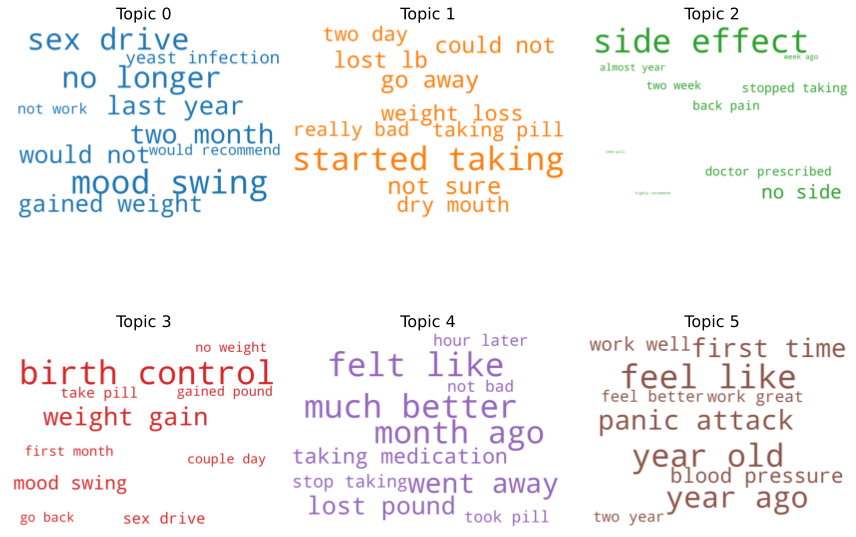

<Figure size 432x288 with 0 Axes>

In [69]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics2 = lda2.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(12,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words2 = dict(topics2[i][1])
    cloud.generate_from_frequencies(topic_words2, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

plt.savefig('C:/Users/ND/Documents/GitHub/drug-recommendation/fig/wc_bigram_lda-6.svg')